In [26]:
import pandas as pd

df = pd.read_csv('new_data.csv')



df = df.drop(columns=['Normalized'])
df['total_biomass'] = df['total_biomass']/ 1e6
threshold = int(len(df)*0.9)
train = df.iloc[:threshold]
test = df.iloc[threshold:]

train.to_csv('train.csv',index = False)
test.to_csv('test.csv',index = False)

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

class TimeSeriesForecaster:
    def __init__(self, seasonality=12):
        self.seasonality = seasonality
        self.scaler = RobustScaler()
        self.models = {}

    def plot_results(self, train_data, test_data, predictions, target_col):
        """Plot actual vs predicted values."""
        plt.figure(figsize=(12, 6))
        
        # Plot training data
        plt.plot(train_data['Year'], train_data[target_col], 
                label='Training Data', color='blue', alpha=0.7)
        
        # Plot test data
        plt.plot(test_data['Year'], test_data[target_col], 
                label='Actual Test Data', color='green', alpha=0.7)
        
        # Plot predictions
        plt.plot(test_data['Year'], predictions, 
                label='Predictions', color='red', 
                linestyle='--', alpha=0.8)
        
        # Customize plot
        plt.title('Time Series Forecasting Results', fontsize=14, pad=20)
        plt.xlabel('Year', fontsize=12)
        plt.ylabel(target_col, fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)
        
        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45)
        
        # Adjust layout to prevent label cutoff
        plt.tight_layout()
        
        plt.show()
    
    def create_features(self, df, target_col):
        """Create enhanced time series features from datetime index."""
        df = df.copy()
        df['year'] = df['Year'].astype(int)
        
        # Enhanced lag features
        for lag in range(1, 7):
            df[f'lag_{lag}'] = df[target_col].shift(lag)
        
        # Enhanced rolling statistics
        for window in [3, 6, 12, 24]:
            df[f'rolling_mean_{window}'] = df[target_col].rolling(
                window=window, min_periods=1).mean()
            df[f'rolling_std_{window}'] = df[target_col].rolling(
                window=window, min_periods=1).std()
            df[f'rolling_min_{window}'] = df[target_col].rolling(
                window=window, min_periods=1).min()
            df[f'rolling_max_{window}'] = df[target_col].rolling(
                window=window, min_periods=1).max()
            
        # Exponential moving averages
        for span in [3, 6, 12]:
            df[f'ema_{span}'] = df[target_col].ewm(span=span, adjust=False).mean()
        
        # Trend and cyclical features
        df['trend'] = np.arange(len(df))
        df['trend_squared'] = df['trend'] ** 2
        df['year_mod'] = df['year'] % self.seasonality
        
        # Difference features
        df['diff_1'] = df[target_col].diff()
        df['diff_2'] = df[target_col].diff().diff()
        
        return df
    
    def prepare_data(self, train_df, test_df, target_col):
        """Prepare data with enhanced preprocessing."""
        # Create features
        train_featured = self.create_features(train_df, target_col)
        test_featured = self.create_features(test_df, target_col)
        
        # Prepare features and target
        feature_cols = [col for col in train_featured.columns 
                       if col not in [target_col, 'Year']]
        
        X_train = train_featured[feature_cols].copy()
        y_train = train_featured[target_col]
        X_test = test_featured[feature_cols].copy()
        y_test = test_featured[target_col]
        
        # Handle missing values more robustly
        for col in X_train.columns:
            X_train[col] = X_train[col].fillna(X_train[col].median())
            X_test[col] = X_test[col].fillna(X_test[col].median())
        
        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        return (X_train_scaled, y_train, X_test_scaled, y_test,
                train_featured, test_featured, feature_cols)
    
    def train_lightgbm(self, X_train, y_train):
        """Train LightGBM with optimized parameters."""
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'num_leaves': 20,
            'learning_rate': 0.001,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'num_iterations': 5000,
            'early_stopping_rounds': 200,
            'verbose': -1,
            'reg_alpha': 0.1,
            'reg_lambda': 0.1,
            'min_child_samples': 20
        }
        
        # Create dataset with validation
        tscv = TimeSeriesSplit(n_splits=5)
        for train_idx, val_idx in tscv.split(X_train):
            X_train_split, X_val = X_train[train_idx], X_train[val_idx]
            y_train_split, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
        lgb_train = lgb.Dataset(X_train_split, y_train_split)
        lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)
        
        # Train model
        self.models['lgb'] = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_train, lgb_val],
            valid_names=['train', 'valid']
        )
    
    def train_sarima(self, y_train):
        """Train SARIMA with optimized parameters."""
        # Grid search for best parameters
        best_aic = float('inf')
        best_order = None
        best_seasonal_order = None
        
        for p in range(2):
            for d in range(2):
                for q in range(2):
                    for P in range(2):
                        for D in range(2):
                            for Q in range(2):
                                try:
                                    model = SARIMAX(
                                        y_train,
                                        order=(p, d, q),
                                        seasonal_order=(P, D, Q, self.seasonality)
                                    ).fit(disp=False)
                                    if model.aic < best_aic:
                                        best_aic = model.aic
                                        best_order = (p, d, q)
                                        best_seasonal_order = (P, D, Q, self.seasonality)
                                except:
                                    continue
        
        # Train final model with best parameters
        self.models['sarima'] = SARIMAX(
            y_train,
            order=best_order if best_order else (1, 1, 1),
            seasonal_order=best_seasonal_order if best_seasonal_order else (1, 1, 1, self.seasonality)
        ).fit(disp=False)
    
    def ensemble_predict(self, X_test):
        """Make weighted ensemble predictions."""
        # Get predictions from both models
        lgb_preds = self.models['lgb'].predict(X_test)
        sarima_preds = self.models['sarima'].forecast(len(X_test))
        
        # Use weighted average (giving more weight to LightGBM as it handles features better)
        ensemble_preds = 0.7 * lgb_preds + 0.3 * sarima_preds
        
        return ensemble_preds

    def fit_predict(self, train_df, test_df, target_col):
        """Full training and prediction pipeline with error handling."""
        try:
            # Prepare data
            (X_train_scaled, y_train, X_test_scaled, y_test,
             train_data, test_data, feature_cols) = self.prepare_data(
                train_df, test_df, target_col)
            
            # Train models
            self.train_lightgbm(X_train_scaled, y_train)
            self.train_sarima(y_train)
            
            # Make predictions
            predictions = self.ensemble_predict(X_test_scaled)
            
            # Calculate metrics
            mse = mean_squared_error(y_test, predictions)
            r2 = r2_score(y_test, predictions)
            
            print(f"Mean Squared Error: {mse:.2f}")
            print(f"R² Score: {r2:.2f}")
            
            # Plot results
            self.plot_results(train_data, test_data, predictions, target_col)
            
            return predictions
            
        except Exception as e:
            print(f"Error in fit_predict: {str(e)}")
            raise

In [9]:
# Load data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Initialize and train the model
forecaster = TimeSeriesForecaster(seasonality=12)
predictions = forecaster.fit_predict(train_df, test_df, 'total_biomass')

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

def create_sequences(data, seq_length):
    """Create sequences for LSTM input"""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Load and preprocess data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Extract total_biomass and normalize data
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_df['total_biomass'].values.reshape(-1, 1))
test_data = scaler.transform(test_df['total_biomass'].values.reshape(-1, 1))

# Parameters
sequence_length = 3  # Number of time steps to look back
epochs = 100
batch_size = 32

# Create sequences
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Reshape input data for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Create LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mse')

# Train model
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    verbose=1
)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform(y_test)

# Plot results
plt.figure(figsize=(15, 6))

# Plot training data
plt.plot(train_df['Year'][sequence_length:], y_train_inv, 
         label='Actual Training Data', color='blue')
plt.plot(train_df['Year'][sequence_length:], train_predict, 
         label='Training Predictions', color='red', linestyle='--')

# Plot testing data
test_years = test_df['Year'][sequence_length:]
plt.plot(test_years, y_test_inv, 
         label='Actual Testing Data', color='green')
plt.plot(test_years, test_predict, 
         label='Testing Predictions', color='orange', linestyle='--')

plt.title('Total Biomass Forecasting with LSTM')
plt.xlabel('Year')
plt.ylabel('Total Biomass')
plt.legend()
plt.grid(True)
plt.show()

# Function to make future predictions
def forecast_future(model, last_sequence, num_steps, scaler):
    """
    Forecast future values using the trained LSTM model
    
    Parameters:
    model: trained LSTM model
    last_sequence: last sequence from the training data
    num_steps: number of future steps to predict
    scaler: fitted MinMaxScaler object
    
    Returns:
    Array of predicted values
    """
    future_predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(num_steps):
        # Reshape sequence for prediction
        current_sequence_reshaped = current_sequence.reshape((1, sequence_length, 1))
        # Get prediction
        next_pred = model.predict(current_sequence_reshaped)
        # Add prediction to list
        future_predictions.append(next_pred[0, 0])
        # Update sequence
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred
        
    # Inverse transform predictions
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    future_predictions = scaler.inverse_transform(future_predictions)
    
    return future_predictions

# Get the last sequence from training data
last_sequence = train_data[-sequence_length:]

# Forecast next 10 years
num_future_steps = 10
future_predictions = forecast_future(model, last_sequence, num_future_steps, scaler)

# Create future years for plotting
last_year = test_df['Year'].iloc[-1]
future_years = np.arange(last_year + 1, last_year + num_future_steps + 1)

# Plot with future predictions
plt.figure(figsize=(15, 6))
plt.plot(train_df['Year'][sequence_length:], y_train_inv, 
         label='Training Data', color='blue')
plt.plot(test_years, y_test_inv, 
         label='Testing Data', color='green')
plt.plot(future_years, future_predictions, 
         label='Future Predictions', color='red', linestyle='--')
plt.title('Total Biomass Forecasting with Future Predictions')
plt.xlabel('Year')
plt.ylabel('Total Biomass')
plt.legend()
plt.grid(True)
plt.show()

# Print model evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate metrics for test set
mse = mean_squared_error(y_test_inv, test_predict)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, test_predict)
r2 = r2_score(y_test_inv, test_predict)

print("\nModel Evaluation Metrics on Test Set:")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R-squared Score: {r2:.4f}")

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def create_sequences(data, seq_length):
    """Create sequences for LSTM input"""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

def create_features(data, target, lookback):
    """Create features for XGBoost"""
    df = pd.DataFrame(data)
    for i in range(1, lookback + 1):
        df[f'lag_{i}'] = df[target].shift(i)
    df = df.dropna()
    return df

# Load and preprocess data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Extract total_biomass and normalize data for LSTM
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_df['total_biomass'].values.reshape(-1, 1))
test_data = scaler.transform(test_df['total_biomass'].values.reshape(-1, 1))

# Parameters
sequence_length = 5
epochs = 100
batch_size = 32
lookback = sequence_length  # Make sure lookback equals sequence_length

# Create sequences for LSTM
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Reshape input data for LSTM [samples, time steps, features]
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Create and train LSTM model
lstm_model = Sequential([ 
    LSTM(50, activation='relu', input_shape=(sequence_length, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=epochs, batch_size=batch_size, 
               validation_split=0.1, verbose=1)

# LSTM predictions
lstm_train_predict = scaler.inverse_transform(lstm_model.predict(X_train_lstm))
lstm_test_predict = scaler.inverse_transform(lstm_model.predict(X_test_lstm))
y_train_inv = scaler.inverse_transform(y_train)
y_test_inv = scaler.inverse_transform(y_test)

# Prepare data for ARIMA
arima_train = train_df['total_biomass'].values
arima_test = test_df['total_biomass'].values

# Fit ARIMA model
arima_model = ARIMA(arima_train, order=(1,1,1))
arima_fit = arima_model.fit()

# Make ARIMA predictions
arima_train_predict = arima_fit.predict(start=sequence_length, 
                                      end=len(arima_train)-1)
arima_test_predict = arima_fit.forecast(steps=len(arima_test)-sequence_length)

# Prepare data for XGBoost
train_features = create_features(train_df['total_biomass'], 'total_biomass', lookback)
test_features = create_features(test_df['total_biomass'], 'total_biomass', lookback)

X_train_xgb = train_features.drop('total_biomass', axis=1)
y_train_xgb = train_features['total_biomass']
X_test_xgb = test_features.drop('total_biomass', axis=1)
y_test_xgb = test_features['total_biomass']

# Create and train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train_xgb, y_train_xgb)

# XGBoost predictions
xgb_train_predict = xgb_model.predict(X_train_xgb)
xgb_test_predict = xgb_model.predict(X_test_xgb)

# Prepare time axes with correct dimensions
train_years = train_df['Year'][sequence_length:].values
test_years = test_df['Year'][sequence_length:].values

# Plot results with only Train and Test Data (Discontinuous graph)
plt.figure(figsize=(15, 10))

# Training data
plt.plot(train_years, y_train_inv, label='Actual Training Data', color='blue')
plt.plot(train_years, lstm_train_predict, 
         label='LSTM Training Predictions', color='red', linestyle='--')
plt.plot(train_years, arima_train_predict, 
         label='ARIMA Training Predictions', color='green', linestyle='--')
plt.plot(train_years, xgb_train_predict, 
         label='XGBoost Training Predictions', color='purple', linestyle='--')

# Testing data
plt.plot(test_years, y_test_inv, label='Actual Testing Data', color='black')
plt.plot(test_years, lstm_test_predict, 
         label='LSTM Testing Predictions', color='orange', linestyle='--')
plt.plot(test_years, arima_test_predict, 
         label='ARIMA Testing Predictions', color='brown', linestyle='--')
plt.plot(test_years, xgb_test_predict, 
         label='XGBoost Testing Predictions', color='cyan', linestyle='--')

plt.title('Total Biomass Forecasting - Model Comparison')
plt.xlabel('Year')
plt.ylabel('Total Biomass')
plt.legend()
plt.grid(True)
plt.show()

# Print model evaluation metrics for all models
def print_metrics(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Evaluation Metrics:")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  R-squared (R2): {r2:.4f}\n")

print_metrics(y_train_inv, lstm_train_predict, "LSTM Training")
print_metrics(y_test_inv, lstm_test_predict, "LSTM Testing")
print_metrics(y_train_inv, arima_train_predict, "ARIMA Training")
print_metrics(y_test_inv, arima_test_predict, "ARIMA Testing")
print_metrics(y_train_xgb, xgb_train_predict, "XGBoost Training")
print_metrics(y_test_xgb, xgb_test_predict, "XGBoost Testing")

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


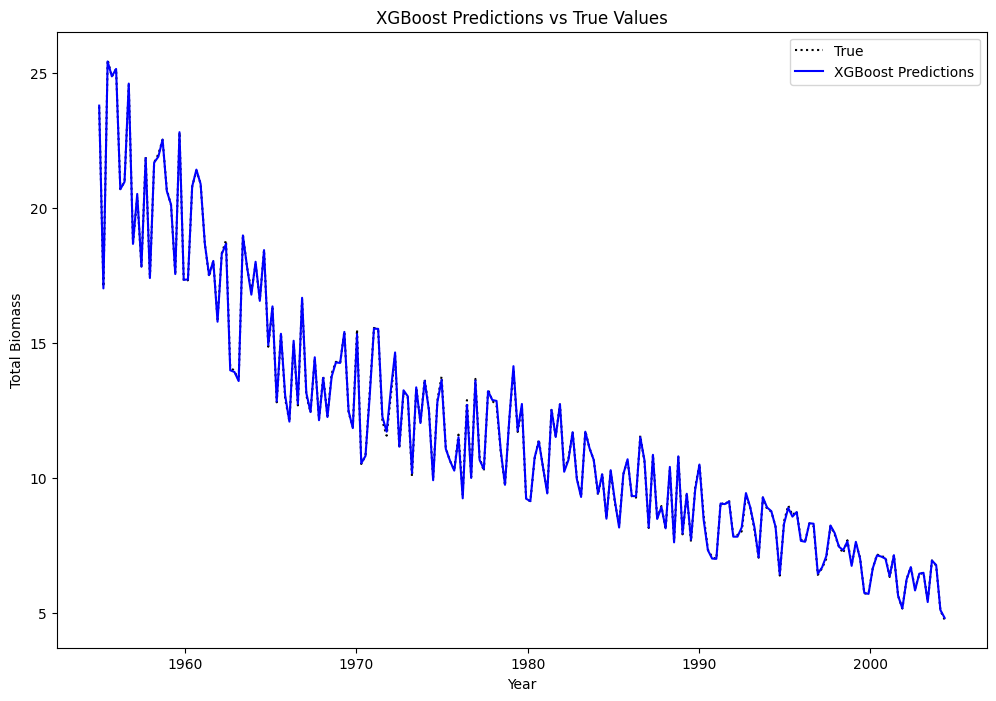

RMSE: 0.06301584542914754
R^2: 0.9998179803584967


In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load and prepare the data
data = pd.read_csv('train.csv')
data = data.sort_values('Year')
X = data.drop(['Year', 'total_biomass'], axis=1)
y = data['total_biomass']

# Split the data using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the model and hyperparameters
model = XGBRegressor(objective='reg:squarederror', random_state=42)
params = {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 5, 7]
}

# Train the model using GridSearchCV
grid = GridSearchCV(model, params, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_scaled, y)
best_model = grid.best_estimator_
print(f"Best parameters: {grid.best_params_}")

# Predict and evaluate
y_pred = best_model.predict(X_scaled)

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(data['Year'], y, label='True', color='black', linestyle='dotted')
plt.plot(data['Year'], y_pred, label='XGBoost Predictions', color='blue')
plt.title('XGBoost Predictions vs True Values')
plt.xlabel('Year')
plt.ylabel('Total Biomass')
plt.legend()
plt.show()

# Print evaluation metrics
print(f"RMSE: {np.sqrt(mean_squared_error(y, y_pred))}")
print(f"R^2: {r2_score(y, y_pred)}")

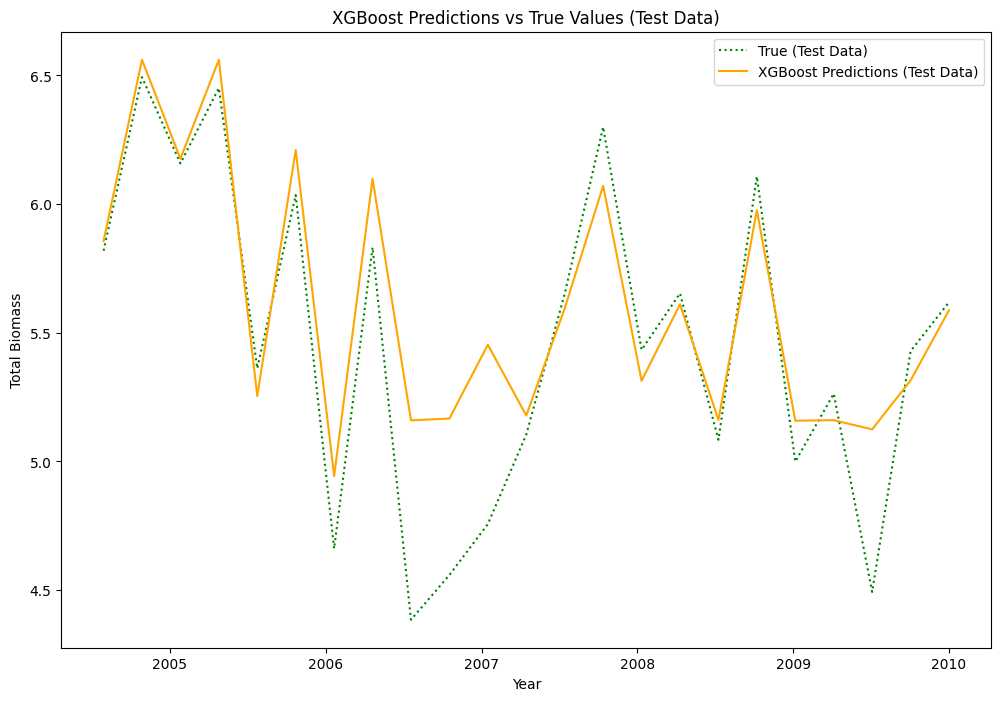

Test RMSE: 0.3104196515307929
Test R^2: 0.7517054969772434


In [28]:
# Load and prepare the test data
test_data = pd.read_csv('test.csv')
test_data = test_data.sort_values('Year')  # Ensure test data is sorted by 'Year'
X_test = test_data.drop(['Year', 'total_biomass'], axis=1)
y_test = test_data['total_biomass']

# Scale the test data
X_test_scaled = scaler.transform(X_test)  # Use the scaler fitted on training data

# Make predictions on the test data
y_test_pred = best_model.predict(X_test_scaled)

# Plot predictions vs true values for the test data
plt.figure(figsize=(12, 8))
plt.plot(test_data['Year'], y_test, label='True (Test Data)', color='green', linestyle='dotted')
plt.plot(test_data['Year'], y_test_pred, label='XGBoost Predictions (Test Data)', color='orange')
plt.title('XGBoost Predictions vs True Values (Test Data)')
plt.xlabel('Year')
plt.ylabel('Total Biomass')
plt.legend()
plt.show()

# Print evaluation metrics for test data
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred))}")
print(f"Test R^2: {r2_score(y_test, y_test_pred)}")

#run ----------

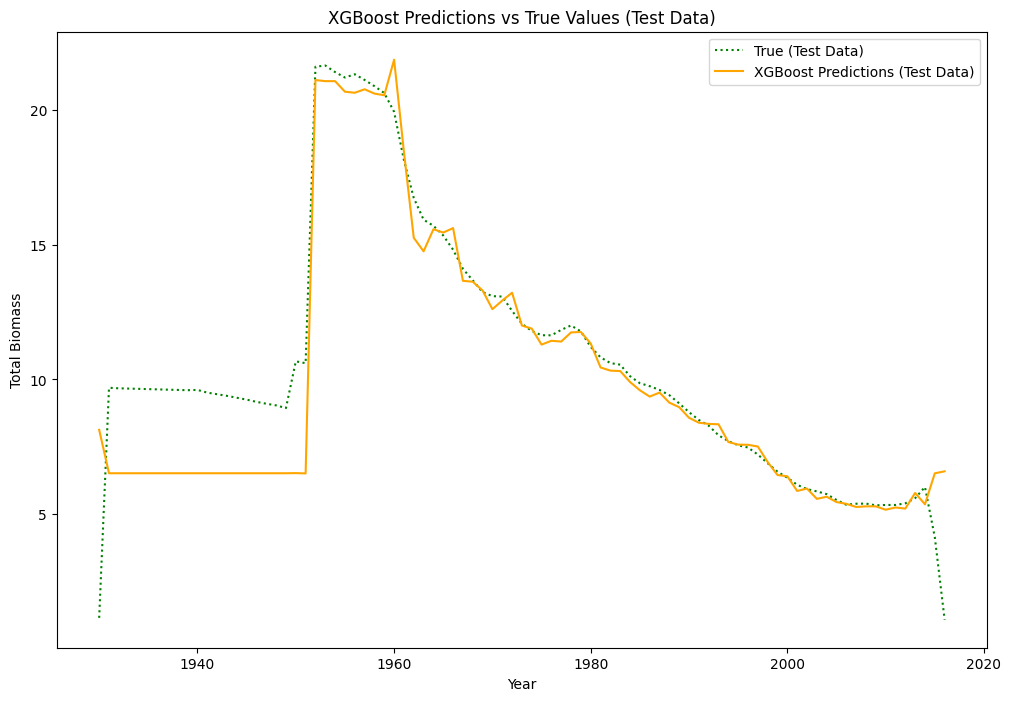

Test RMSE: 1.8461645444689572
Test R^2: 0.8483231195390186


In [29]:
# Load and prepare the test data
test_data = pd.read_csv('clean3.csv')
test_data = test_data.sort_values('Year')  # Ensure test data is sorted by 'Year'
X_test = test_data.drop(['Year', 'total_biomass'], axis=1)
y_test = test_data['total_biomass']/1e6

# Scale the test data
X_test_scaled = scaler.transform(X_test)  # Use the scaler fitted on training data

# Make predictions on the test data
y_test_pred = best_model.predict(X_test_scaled)

# Plot predictions vs true values for the test data
plt.figure(figsize=(12, 8))
plt.plot(test_data['Year'], y_test, label='True (Test Data)', color='green', linestyle='dotted')
plt.plot(test_data['Year'], y_test_pred, label='XGBoost Predictions (Test Data)', color='orange')
plt.title('XGBoost Predictions vs True Values (Test Data)')
plt.xlabel('Year')
plt.ylabel('Total Biomass')
plt.legend()
plt.show()

# Print evaluation metrics for test data
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred))}")
print(f"Test R^2: {r2_score(y_test, y_test_pred)}")

#run ----------

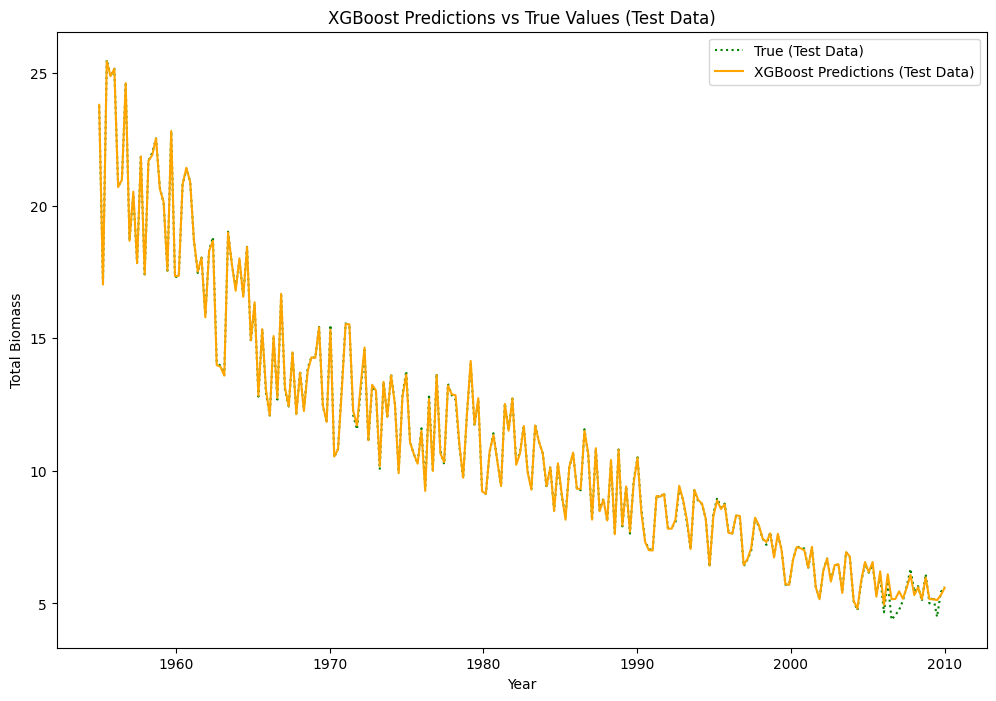

Test RMSE: 0.11600605420440092
Test R^2: 0.9994270896500623


In [30]:
# Load and prepare the test data

test_data = pd.read_csv('new_data.csv')
test_data = test_data.drop(columns=['Normalized'])
test_data = test_data.sort_values('Year')  # Ensure test data is sorted by 'Year'
X_test = test_data.drop(['Year', 'total_biomass'], axis=1)
y_test = test_data['total_biomass']/1e6

# Scale the test data
X_test_scaled = scaler.transform(X_test)  # Use the scaler fitted on training data

# Make predictions on the test data
y_test_pred = best_model.predict(X_test_scaled)

# Plot predictions vs true values for the test data
plt.figure(figsize=(12, 8))
plt.plot(test_data['Year'], y_test, label='True (Test Data)', color='green', linestyle='dotted')
plt.plot(test_data['Year'], y_test_pred, label='XGBoost Predictions (Test Data)', color='orange')
plt.title('XGBoost Predictions vs True Values (Test Data)')
plt.xlabel('Year')
plt.ylabel('Total Biomass')
plt.legend()
plt.show()

# Print evaluation metrics for test data
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred))}")
print(f"Test R^2: {r2_score(y_test, y_test_pred)}")

#run ----------

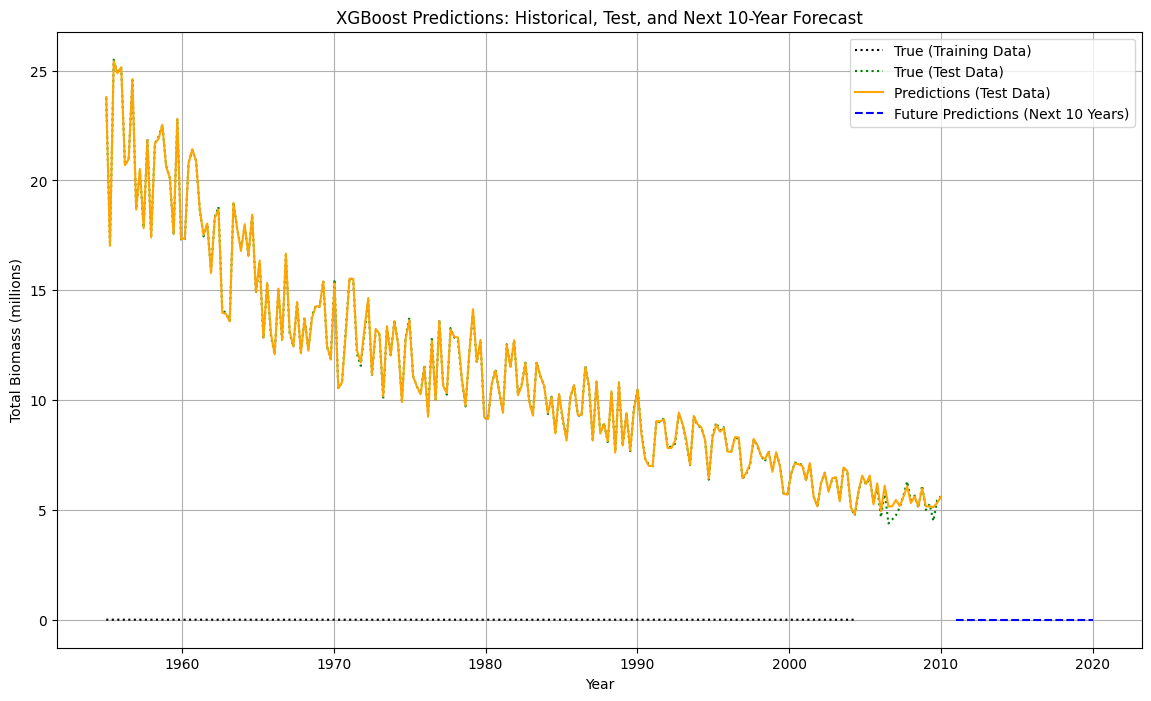

     Year  Predicted_Total_Biomass
0  2011.0                 0.000006
1  2012.0                 0.000006
2  2013.0                 0.000006
3  2014.0                 0.000006
4  2015.0                 0.000006
5  2016.0                 0.000006
6  2017.0                 0.000006
7  2018.0                 0.000006
8  2019.0                 0.000006
9  2020.0                 0.000006


In [31]:
# Define the number of years to predict into the future
future_years = 10
last_year = test_data['Year'].max()  # Start from the last year in the test data
future_year_range = np.arange(last_year + 1, last_year + 1 + future_years)

# Create future feature data (adjust based on your feature set)
# Here, we're assuming the features can be approximated using the last row of the test data.
future_features = X_test.iloc[-1:].copy()  # Use the last known feature row as a template
future_data = pd.concat([future_features] * future_years, ignore_index=True)
future_data['Year'] = future_year_range  # Add the future year range

# Drop the 'Year' column and scale the future data
X_future = future_data.drop('Year', axis=1)
X_future_scaled = scaler.transform(X_future)

# Predict future biomass
y_future_pred = best_model.predict(X_future_scaled) / 1e6  # Scale to match the target units (millions)

# Combine future predictions with years for plotting
plt.figure(figsize=(14, 8))

# Plot historical and test predictions
plt.plot(data['Year'], y / 1e4, label='True (Training Data)', color='black', linestyle='dotted')  # Training data
plt.plot(test_data['Year'], y_test, label='True (Test Data)', color='green', linestyle='dotted')  # Test data
plt.plot(test_data['Year'], y_test_pred, label='Predictions (Test Data)', color='orange')  # Test predictions

# Plot future predictions as a continuation
plt.plot(future_year_range, y_future_pred, label='Future Predictions (Next 10 Years)', color='blue', linestyle='dashed')

# Customize the plot
plt.title('XGBoost Predictions: Historical, Test, and Next 10-Year Forecast')
plt.xlabel('Year')
plt.ylabel('Total Biomass (millions)')
plt.legend()
plt.grid(True)
plt.show()

# Print future predictions as a DataFrame
future_predictions = pd.DataFrame({'Year': future_year_range, 'Predicted_Total_Biomass': y_future_pred})
print(future_predictions)


In [32]:
newby = pd.DataFrame()

newby['Year'] = test_data['Year']

newby['biomass'] = y_test

newby.head()

,Year,biomass
0,1955.000000,23.760914
1,1955.246637,17.086065
2,1955.493274,25.498626
3,1955.739910,24.872255
4,1955.986547,25.159254


In [33]:
newby.to_csv('biomass_data.csv',index=False)

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Load the data
data = pd.read_csv('biomass_data.csv')  # Ensure the file has 'Year' and 'biomass' columns
data.set_index('Year', inplace=True)  # Set 'Year' as the index for proper plotting
data['biomass'] = data['biomass'] * 100  # Scale the biomass values if needed

# Add technical indicators
data['SMA_5'] = data['biomass'].rolling(window=5).mean()  # Simple Moving Average (5 years)
data['EMA_5'] = data['biomass'].ewm(span=5, adjust=False).mean()  # Exponential Moving Average (5 years)
data['SMA_10'] = data['biomass'].rolling(window=10).mean()  # Simple Moving Average (10 years)
data['EMA_10'] = data['biomass'].ewm(span=10, adjust=False).mean()  # Exponential Moving Average (10 years)

# Fill missing values caused by rolling calculations
data.fillna(method='bfill', inplace=True)

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.values)

# Create sequences
sequence_length = 21  # Use a sequence length of 21 to look at the previous 21 years
X, y = [], []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i - sequence_length:i])  # Include all features (biomass + indicators)
    y.append(scaled_data[i, 0])  # Predict the biomass value only
X, y = np.array(X), np.array(y)

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Print shapes to verify
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Build the LSTM model with dropout for regularization
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),  # Updated for multi-feature input
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.2),  # Dropout to prevent overfitting
    LSTM(64, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(
    X_train, y_train,
    epochs=200,  # Increased epochs for better trend capture
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stop]
)

# Forecast the next 20 years
last_sequence = scaled_data[-sequence_length:]
forecast = []

for _ in range(20):
    # Predict the next value
    prediction = model.predict(last_sequence.reshape(1, sequence_length, X_train.shape[2]), verbose=0)
    
    # Append the predicted biomass value to the forecast
    forecast.append(prediction[0, 0])
    
    # Create a new row for the next sequence
    new_row = last_sequence[-1].copy()  # Copy the last row of the sequence
    new_row[0] = prediction[0, 0]  # Replace the biomass value with the predicted value
    last_sequence = np.append(last_sequence[1:], [new_row], axis=0)

# Transform only the biomass column back to its original scale
forecast_biomass = np.array(forecast).reshape(-1, 1)
forecast_biomass = scaler.inverse_transform(
    np.hstack([forecast_biomass] + [np.zeros_like(forecast_biomass)] * (scaled_data.shape[1] - 1))
)[:, 0]

# Handle non-integer years
year_diff = data.index[1] - data.index[0]  # Approximate difference between years
forecast_index = np.arange(data.index.max() + year_diff, data.index.max() + 20 * year_diff, step=year_diff)

# Create the Plotly chart
fig = go.Figure()

# Add observed data
fig.add_trace(go.Scatter(
    x=data.index,
    y=data['biomass'],
    mode='lines+markers',
    name='Observed',
    line=dict(color='blue'),
    marker=dict(size=8)
))

# Add forecasted data
fig.add_trace(go.Scatter(
    x=list(forecast_index),
    y=forecast_biomass,
    mode='lines+markers',
    name='Forecast',
    line=dict(color='red', dash='dash'),
    marker=dict(size=8, symbol='x')
))

# Customize the layout
fig.update_layout(
    title='Biomass Forecast with Technical Indicators (Next 20 Years)',
    xaxis_title='Year',
    yaxis_title='Biomass',
    legend=dict(x=0, y=1),
    template='plotly_white'
)

# Show the interactive chart
fig.show()

# Evaluate the model (Optional)
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(
    np.hstack([y_pred] + [np.zeros_like(y_pred)] * (scaled_data.shape[1] - 1))
)[:, 0]
y_test_inv = scaler.inverse_transform(
    np.hstack([y_test.reshape(-1, 1)] + [np.zeros_like(y_test.reshape(-1, 1))] * (scaled_data.shape[1] - 1))
)[:, 0]

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')


X_train shape: (162, 21, 5)
y_train shape: (162,)
X_test shape: (41, 21, 5)
y_test shape: (41,)
Epoch 1/200


C:\Users\manta\AppData\Local\Temp\ipykernel_14632\2589049307.py:23: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0994 - val_loss: 0.0063
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0146 - val_loss: 0.0021
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0127 - val_loss: 0.0060
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0099 - val_loss: 0.0039
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0077 - val_loss: 0.0046
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0082 - val_loss: 0.0032
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0101 - val_loss: 0.0042
Epoch 8/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0078 - val_loss: 0.0044
Epoch 9/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0056 - val_loss: 0.0042
Epoch 10/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0079 - val_loss: 0.0037
Epoch 11/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0068 - val_loss: 0.0028
Epoch 12/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
Root Mean Squared Error (RMSE): 71.441360390057


In [38]:
print(forecast_biomass)

[574.32086 574.03577 573.86127 573.8187  573.7989  573.86456 573.9117
 574.0119  574.10187 574.1808  574.23975 574.275   574.25793 574.29193
 574.3037  574.33997 574.3163  574.3689  574.4123  574.4621 ]


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('new_data.csv')
data['Year'] = pd.to_datetime(data['Year'], format='%Y')
data.set_index('Year', inplace=True)

# Fit ARIMA model
arima_model = ARIMA(data['total_biomass'], order=(5, 1, 0))
arima_result = arima_model.fit()

# Forecast
forecast = arima_result.forecast(steps=10)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(data['total_biomass'], label='Actual')
plt.plot(forecast, label='Forecast', color='red')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

Preparing fisheries data...

Training Random Forest model...

Model Performance Metrics:
Mean Squared Error: 1337386414646.70
Root Mean Squared Error: 1156454.24
Mean Absolute Error: 935460.19
R² Score: -1.17

Next Year Prediction:
Predicted total catch for next year: 6679540.59

Plotting results...


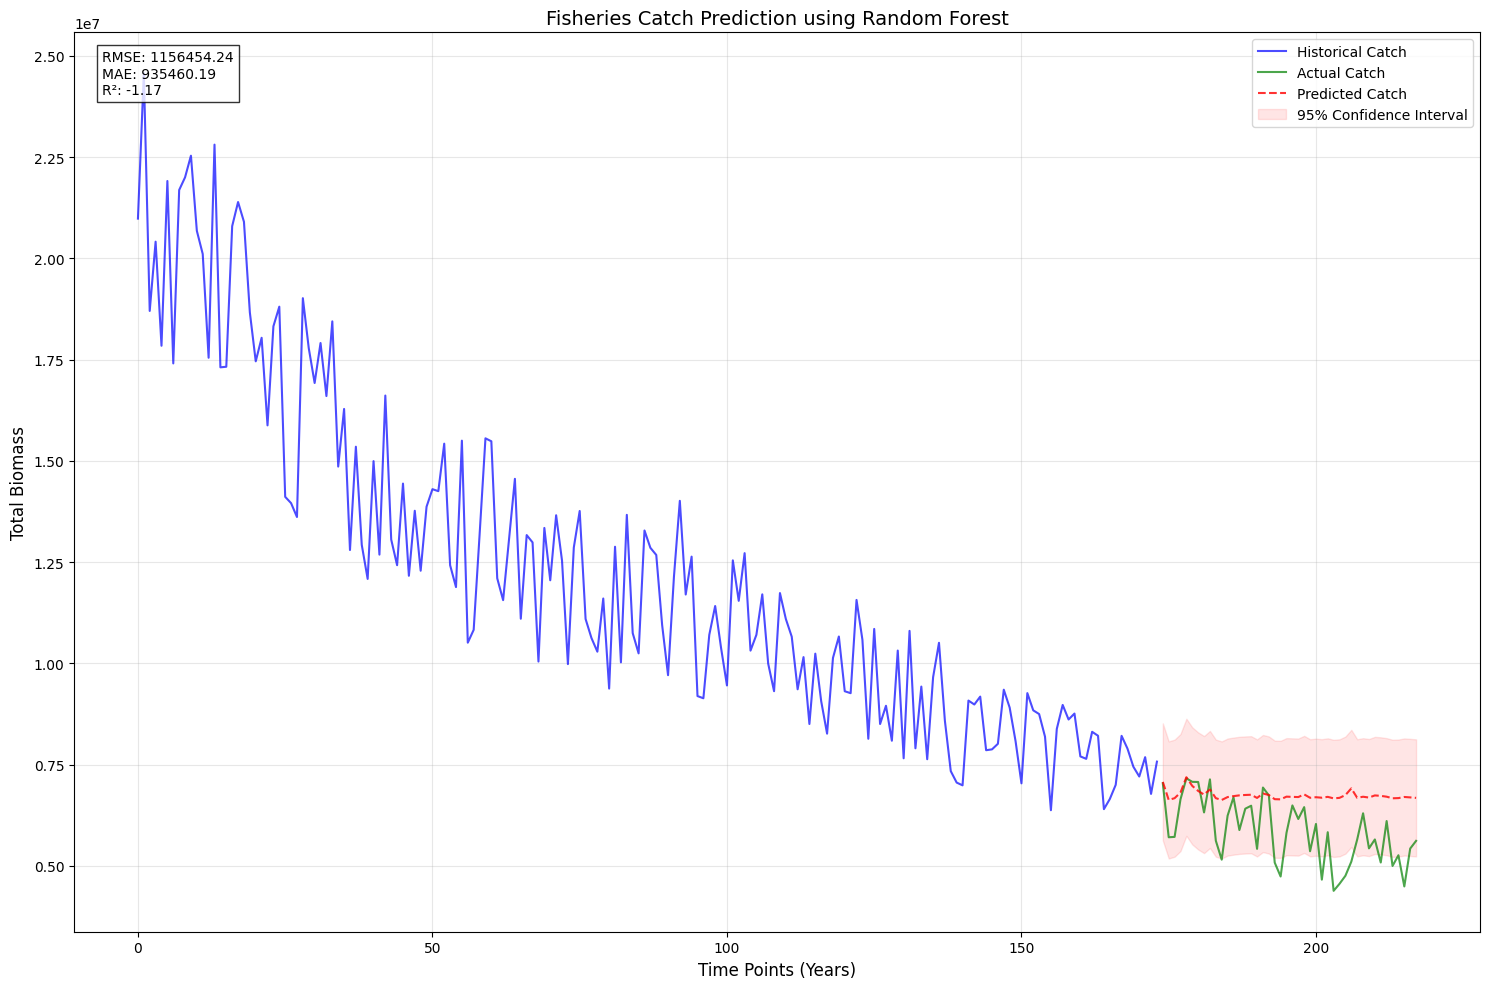

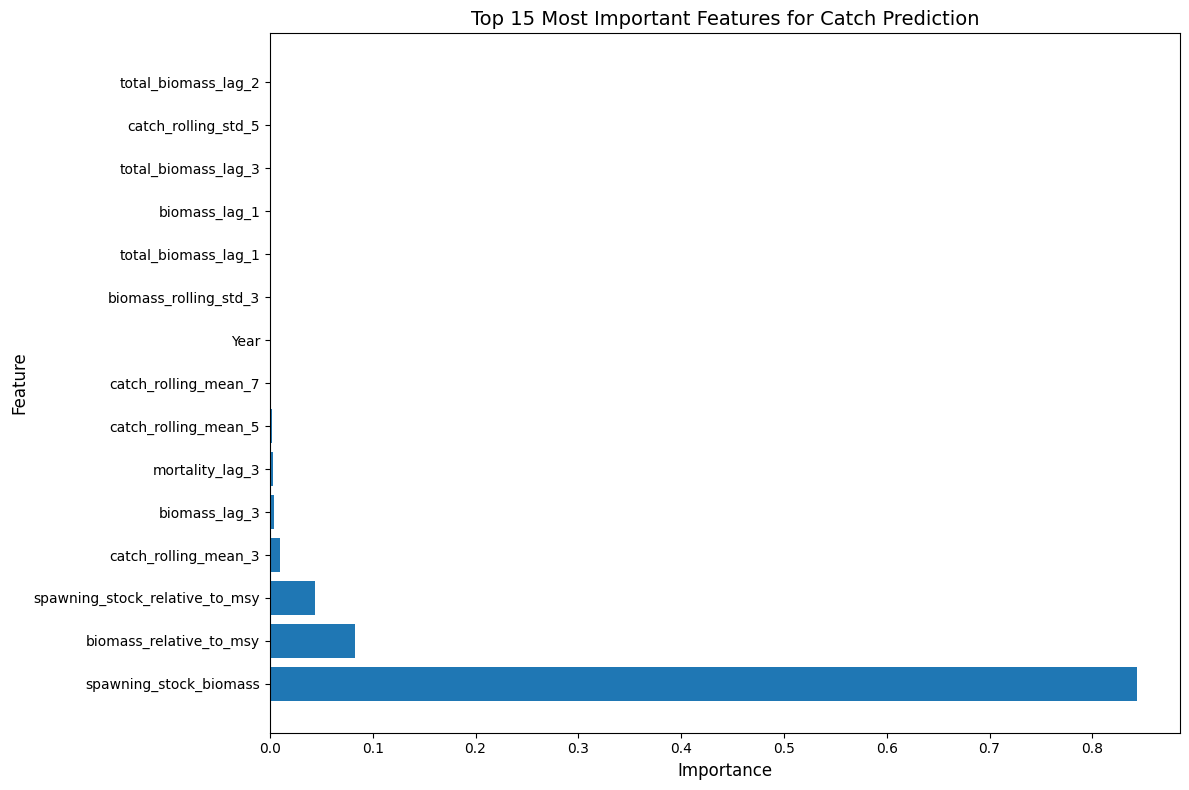

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Read the CSV file
data = pd.read_csv('new_data.csv')

def create_features(df):
    """Create time series features for the Random Forest model"""
    df_features = pd.DataFrame()
    
    # Use relevant fisheries features
    df_features['total_catch'] = df['total_catch']
    df_features['spawning_stock_biomass'] = df['spawning_stock_biomass']
    df_features['fishing_mortality'] = df['fishing_mortality']
    df_features['exploitation_rate'] = df['exploitation_rate']
    df_features['biomass_relative_to_msy'] = df['biomass_relative_to_msy']
    df_features['spawning_stock_relative_to_msy'] = df['spawning_stock_relative_to_msy']
    df_features['fishing_mortality_relative_to_msy'] = df['fishing_mortality_relative_to_msy']
    df_features['Year'] = df['Year']  # Add year as a feature
    
    # Create lagged features for total catch
    for i in range(1, 4):
        df_features[f'total_biomass_lag_{i}'] = df['total_biomass'].shift(i)
        df_features[f'biomass_lag_{i}'] = df['total_catch'].shift(i)
        df_features[f'mortality_lag_{i}'] = df['fishing_mortality'].shift(i)
    
    # Create rolling mean features with different windows
    for window in [3, 5, 7]:
        df_features[f'biomass_rolling_mean_{window}'] = df['total_catch'].rolling(window=window).mean()
        df_features[f'catch_rolling_mean_{window}'] = df['total_biomass'].rolling(window=window).mean()
        df_features[f'mortality_rolling_mean_{window}'] = df['fishing_mortality'].rolling(window=window).mean()
        
    # Add rolling standard deviations
    for window in [3, 5]:
        df_features[f'catch_rolling_std_{window}'] = df['total_biomass'].rolling(window=window).std()
        df_features[f'biomass_rolling_std_{window}'] = df['total_catch'].rolling(window=window).std()
    
    return df_features

def prepare_data(df, target_col='total_biomass'):
    """Prepare data for Random Forest model"""
    # Create features
    features = create_features(df)
    target = df[target_col]
    
    # Remove rows with NaN values
    features = features.dropna()
    target = target[features.index]
    
    # Scale the features
    scaler = StandardScaler()
    features_scaled = pd.DataFrame(
        scaler.fit_transform(features),
        columns=features.columns,
        index=features.index
    )
    
    # Split the data (80-20)
    X_train, X_test, y_train, y_test = train_test_split(
        features_scaled, target, test_size=0.2, shuffle=False
    )
    
    return X_train, X_test, y_train, y_test, scaler

def train_random_forest(X_train, y_train, X_test):
    """Train Random Forest model and make predictions"""
    rf_model = RandomForestRegressor(
        n_estimators=200,  # Increased number of trees
        max_depth=20,
        min_samples_split=4,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1  # Use all available cores
    )
    
    rf_model.fit(X_train, y_train)
    predictions = rf_model.predict(X_test)
    
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return predictions, feature_importance, rf_model

def plot_results(y_train, y_test, predictions):
    """Plot actual vs predicted values"""
    plt.figure(figsize=(15, 10))
    
    # Plot training data
    plt.plot(range(len(y_train)), y_train, 
             label='Historical Catch', color='blue', alpha=0.7)
    
    # Plot test data and predictions
    test_range = range(len(y_train), len(y_train) + len(y_test))
    plt.plot(test_range, y_test, 
             label='Actual Catch', color='green', alpha=0.7)
    plt.plot(test_range, predictions, 
             label='Predicted Catch', color='red', linestyle='--', alpha=0.8)
    
    # Calculate confidence intervals
    residuals = y_test - predictions
    std_dev = np.std(residuals)
    plt.fill_between(test_range,
                     predictions - 2*std_dev,
                     predictions + 2*std_dev,
                     color='red', alpha=0.1,
                     label='95% Confidence Interval')
    
    plt.title('Fisheries Catch Prediction using Random Forest', fontsize=14)
    plt.xlabel('Time Points (Years)', fontsize=12)
    plt.ylabel('Total Biomass', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Add metrics text box
    metrics_text = f'RMSE: {np.sqrt(mean_squared_error(y_test, predictions)):.2f}\n'
    metrics_text += f'MAE: {mean_absolute_error(y_test, predictions):.2f}\n'
    metrics_text += f'R²: {r2_score(y_test, predictions):.2f}'
    
    plt.text(0.02, 0.98, metrics_text,
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top',
             fontsize=10)
    
    plt.tight_layout()
    plt.show()

def plot_feature_importance(feature_importance):
    """Plot feature importance"""
    plt.figure(figsize=(12, 8))
    plt.barh(feature_importance['feature'][:15], 
             feature_importance['importance'][:15])
    plt.title('Top 15 Most Important Features for Catch Prediction', fontsize=14)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Prepare the data
    print("Preparing fisheries data...")
    X_train, X_test, y_train, y_test, scaler = prepare_data(data)

    # Train model and make predictions
    print("\nTraining Random Forest model...")
    predictions, feature_importance, model = train_random_forest(X_train, y_train, X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Print results
    print("\nModel Performance Metrics:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"R² Score: {r2:.2f}")

    # Make next year prediction
    print("\nNext Year Prediction:")
    last_features = X_test.iloc[-1:].copy()
    next_year_prediction = float(model.predict(last_features)[0])  # Convert to float
    print(f"Predicted total catch for next year: {next_year_prediction:.2f}")

    # Visualize results
    print("\nPlotting results...")
    plot_results(y_train, y_test, predictions)
    plot_feature_importance(feature_importance)